# Initialization
## Import Libraries

In [1]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1

In [2]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-06 05:30:35.349080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751779835.550013      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751779835.606321      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ℹ️ Set Global Constants

In [3]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/precis-har-rgb"
DATASET_NAME = DATASET_DIR.split("/")[-1].replace("-", " ").title()

print(DATASET_NAME)

ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = 16
CLASSES_LIST = ALL_CLASS_NAMES[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 5

# set drop out rate
DROPOUT_RATE = 0.5

# set datas
MAX_VIDEO_PER_CLASS = 20

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 30
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.20

# augmentation values
NOISE_FACTOR = 0.02
SHEAR_X= 1
SHEAR_Y= 1

# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

Precis Har Rgb
There are total 16 classes, selected 16 classes
Setting 20/class to train the model.
Image size 128x128 with 5 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


## Set `Seed` Values

In [4]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 📌 Function Definition
## Resize and Frame Extraction

In [5]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.metrics import structural_similarity as ssim

# Placeholder for kmeans_silhouette function
def kmeans_silhouette(sub_features):
    if len(sub_features) < 2:
        return [], [], 1, [0]  # Return empty results for insufficient frames
    
    # Try different k values (2 to min(5, len(sub_features)))
    best_k = 2
    best_labels = None
    best_centers = None
    best_score = -1
    best_indices = []
    
    for k in range(2, min(6, len(sub_features) + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(sub_features)
        if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(sub_features, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_labels = labels
                best_centers = kmeans.cluster_centers_
        
        # Find indices of frames closest to cluster centers
        indices = []
        for i in range(best_k):
            if i in labels:
                cluster_points = sub_features[labels == i]
                distances = np.linalg.norm(cluster_points - best_centers[i], axis=1)
                if len(distances) > 0:
                    idx = np.argmin(distances)
                    indices.append(idx)
    
    return best_labels, best_centers, best_k, indices

# Placeholder for redundancy function
def redundancy(video_path, indices, threshold=0.94):
    if not indices:
        return []
    
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        return indices
    
    # Compute histogram for each frame
    def get_histogram(frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        return hist
    
    filtered_indices = [indices[0]]  # Keep first index
    prev_frame = None
    
    for idx in indices[1:]:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success:
            continue
        hist = get_histogram(frame)
        
        if prev_frame is not None:
            # Compute histogram correlation
            corr = cv2.compareHist(get_histogram(prev_frame), hist, cv2.HISTCMP_CORREL)
            if corr < threshold:  # Keep frame if significantly different
                filtered_indices.append(idx)
        prev_frame = frame
    
    video_reader.release()
    return filtered_indices

# Modified scen_keyframe_extraction function
def scen_keyframe_extraction(video_path,  file_name, video_index, is_last_video, num_segments=3):
    # Open video to get frame count
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        raise ValueError(f"Failed to open video {video_path}.")
    
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        video_reader.release()
        raise ValueError(f"No frames in video {video_path}.")
    
    # Generate synthetic scene segmentation (divide video into equal segments)
    segment_length = frame_count // num_segments
    number_list = []
    for i in range(num_segments):
        start = i * segment_length
        end = min((i + 1) * segment_length, frame_count)
        number_list.extend([start, end])

    features = []
    frame_idx = 0
    
    while True:
        success, frame = video_reader.read()
        if not success:
            break
    
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        features.append(hist.flatten())
        
        frame_idx += 1
    
    video_reader.release()
    features = np.asarray(features)
    
    # Clustering at each shot to obtain keyframe sequence numbers
    keyframe_index = []
    for i in range(0, len(number_list), 2):
        start = number_list[i]
        end = min(number_list[i + 1], len(features))
        if end <= start:
            continue
        sub_features = features[start:end]
        best_labels, best_centers, k, indices = kmeans_silhouette(sub_features)
        final_index = [x + start for x in indices if x + start < frame_count]
        final_index = redundancy(video_path, final_index, 0.94)
        keyframe_index += final_index
    
    keyframe_index = sorted(list(set(keyframe_index)))  # Remove duplicates and sort
    # print("final_index:", keyframe_index, end="\r", flush=True)
    
    # Visualize keyframes
    num_keyframes = len(keyframe_index)
    if num_keyframes == 0:
        print("No keyframes extracted.")
        return
    
    video_reader = cv2.VideoCapture(video_path)
    class_name = os.path.basename(os.path.dirname(video_path))
    # print(keyframe_index)
    frames=[]
    frames_index=[]
    for idx, frame_idx in enumerate(keyframe_index, 1):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video_reader.read()
        if not success:
            continue
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        try:
            resized_frame = cv2.resize(rgb_frame, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
            normalized_frame = resized_frame.astype('float32') / 255.0

            
            if normalized_frame.shape != (IMAGE_HEIGHT, IMAGE_WIDTH, 3):
                print(f"Warning: Frame at index {frame_idx} has incorrect shape: {normalized_frame.shape}")
                continue  # Skip malformed frame
            if is_last_video and idx == num_keyframes:
                print(f"Extracted {len(frames)+1} frames from file {video_index+1}: {file_name}", end="\n", flush=True)
            else:
                print(f"Extracted {len(frames)+1} frames from file {video_index+1}: {file_name}", end="\r", flush=True)
                
            frames.append(normalized_frame)
            frames_index.append(frame_idx)
        
        except Exception as e:
            print(f"Error processing frame {frame_idx}: {e}")
            continue
    video_reader.release()

    # handle inhomogenous frames or shape mismatch
    if len(frames) > SEQUENCE_LENGTH:
        # if it is greater than sequence length then leave the last frames
        frames=frames[:SEQUENCE_LENGTH]
    
    frames=np.asarray(frames)
    frames_index=np.asarray(frames_index)
    return frames, frames_index


def show_frames(frames, index):
    num_keyframes = len(frames)
    plt.figure(figsize=(5 * num_keyframes, 5))

    for plot_index, (i, frame) in enumerate(zip(index, frames), start=1):
        frame_label = f"(Frame {i})"
        frame = frame.copy()  # Ensure cv2.putText doesn't affect original
        cv2.putText(frame, frame_label, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        plt.subplot(1, num_keyframes, plot_index)
        plt.imshow(frame)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('ucf50_biking_keyframe_summary.jpg', bbox_inches='tight', dpi=300)
    plt.show()

    
# # Run the keyframe extraction
# sequence, index = scen_keyframe_extraction(video_path, num_segments=5)

# print(sequence.shape)

# show_frames(sequence, index)

### ❌ DEPRECIATED Resize and Frame Extraction

In [6]:
# Resize and Frame Extraction
import cv2
from concurrent.futures import ThreadPoolExecutor

def resize_and_normalize_frame(frame, image_height, image_width):
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture with optimized settings
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Pre-allocate frame indices to extract
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]

    # Read and process frames in parallel
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    # Release the VideoCapture object early
    video_reader.release()

    # Ensure the correct number of frames is read
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None

    # Process frames in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), 
            frames
        ))

    # Check for any failed frame processing
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None

    # Convert to NumPy array
    frames_array = np.array(processed_frames, dtype=np.float32)

    return frames_array

In [7]:
 # # Iterate through all video files
 #        for file_name in files_list:
 #            video_file_path = os.path.join(class_path, file_name)

 #            # Extract frames using the updated frames_extraction function
 #            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

 #            # Skip videos where frame extraction failed
 #            if frames is None:
 #                print(f"Skipping video {video_file_path} due to frame extraction failure")
 #                continue

 #            # Append the data to respective lists
 #            features.append(frames)
 #            labels.append(class_index)

## Create Dataset

In [8]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    videos = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Class {class_index}: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        is_last_video=False
        for (index, file_name) in enumerate(files_list):
            video_file_path = os.path.join(class_path, file_name)

            if index == (len(files_list)-1):
                is_last_video=True
                # print(f'Extracting frames from file {index+1}: {file_name}', flush=True)
            else:
                is_last_video=False
                # print(f'Extracting frames from file {index+1}: {file_name}', end="\r", flush=True)
            
            # Extract frames using the updated frames_extraction function
            # frames = frames_extraction(video_file_path, 
            #                            sequence_length, 
            #                            image_height, 
            #                            image_width)
            frames, index = scen_keyframe_extraction(video_path=video_file_path, 
                                                     file_name=file_name,
                                                     video_index=index,
                                                     is_last_video=is_last_video,
                                                     num_segments=SEQUENCE_LENGTH)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            videos.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not videos:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    videos = np.asarray(videos)
    labels = np.array(labels)

    print(f"Dataset created with {len(videos)} videos")
    print(f"Features shape: {videos.shape}")
    print(f"Labels shape: {labels.shape}")

    return videos, labels

## 🪄 Video Data Generator

In [9]:
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import numpy as np
import cv2




class VideoDataGenerator(Sequence):
    def __init__(self, videos, labels, batch_size, is_training=False):
        self.videos = list(videos)  # List of video file paths
        self.labels = list(labels)  # List or array of labels encoded
        self.batch_size = batch_size
        self.indices = np.arange(len(self.videos))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied
        self.temp_videos=[]
        self.temp_labels=[]
        
        
        print(f"Total {len(videos)} videos and {len(labels)} classes")

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.videos) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each video in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.videos[index]
            label = self.labels[index]
            
            # Append the sequence and label
            all_frames.append(sequence)
            all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        all_labels = np.array(all_labels)
            
        
        return all_frames, all_labels
    def add(self, new_videos, new_labels):
        self.temp_videos.extend(new_videos)
        self.temp_labels.extend(new_labels)
    
    def confirm(self):
        self.videos.extend(self.temp_videos)
        self.labels.extend(self.temp_labels)
        print(f"Successfully added - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        self.temp_videos=[]
        self.temp_labels=[]
        self.indices = np.arange(len(self.videos))
        print(f"Now Total - {len(self.videos)} videos and {len(self.labels)} classes.")
        print(f"PENDING for Augmentations - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        
    def replace_original(self):
        self.videos=self.temp_videos
        self.labels=self.temp_labels
        self.temp_videos=[]
        self.temp_labels=[]
        print(f"Successfully replaced, total original videos - {len(self.videos)} and augmented videos {len(self.temp_videos)}")
        
    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
        self.labels=np.array(self.labels)
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                (None, NO_OF_CLASSES)
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

## 🔥 Segmentation using N-Frames Ensemble

In [10]:
import cv2
import numpy as np
from collections import deque
import mediapipe as mp

# Parameters
N_FRAMES = 5  # Number of frames for ensemble
THRESHOLD = 0.2  # Segmentation confidence threshold

def initialize_segmentor():
    """Initialize MediaPipe Selfie Segmentation with error handling."""
    try:
        mp_selfie_segmentation = mp.solutions.selfie_segmentation
        segmentor = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)  # 1 for general model
        print("MediaPipe initialized successfully")
        return segmentor
    except Exception as e:
        print(f"Failed to initialize MediaPipe: {e}")
        return None

# Initialize segmentor
segmentor = initialize_segmentor()


def segmentation_frames(sequence):
    """Process a sequence of frames with N-frame ensemble segmentation."""
    # Input sequence: (sequence_length, height, width, 3), values in [0, 1]
    sequence_length, height, width, _ = sequence.shape
    segmented_sequence = np.zeros_like(sequence, dtype=np.float32)
    
    if segmentor is None:
        print("Returning original sequence due to initialization failure")
        return sequence  # Fallback to original sequence
    # Queue to store segmentation masks
    mask_queue = deque(maxlen=N_FRAMES)
    
    # Kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    for t in range(sequence_length):
        try:
            # Convert frame to uint8 for MediaPipe
            frame = (sequence[t] * 255).astype(np.uint8)
            
            # Process frame with MediaPipe
            results = segmentor.process(frame)
            if results.segmentation_mask is None:
                print(f"Warning: No mask returned for frame {t}")
                mask = np.zeros((height, width), dtype=np.float32)
            else:
                mask = results.segmentation_mask  # Shape: (height, width), values in [0, 1]
            
            # Add mask to queue
            mask_queue.append(mask)
            
            # Compute ensemble mask by averaging (if enough frames)
            ensemble_mask = np.mean(np.array(mask_queue), axis=0) if len(mask_queue) > 1 else mask
            
            # Binarize the ensemble mask
            binary_mask = (ensemble_mask > THRESHOLD).astype(np.uint8)
            
            # Refine the mask using morphological operations
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
            
            # Convert binary mask to 3 channels
            mask_3ch = np.stack([binary_mask] * 3, axis=-1)  # Shape: (height, width, 3)
            
            # Apply mask to isolate human subject (set background to black)
            segmented_frame = frame * mask_3ch
            
            # Normalize back to [0, 1]
            segmented_sequence[t] = segmented_frame / 255.0
        
        except Exception as e:
            print(f"Error processing frame {t}: {e}")
            segmented_sequence[t] = sequence[t]  # Fallback to original frame
    
    return segmented_sequence

MediaPipe initialized successfully


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 💫 Augmentation Helper function

In [11]:
def apply_augmentation(augmentation_function, generator, confirm=False, *args, **kwargs):
    count=0
    for i in range(len(generator)):
        batch_videos, batch_labels = generator[i]
        augmented_videos=[]
        for videos in batch_videos:
            count=count+1
            augmented_videos.append(augmentation_function(videos, *args, **kwargs))
            print(f"Adding {count} new videos...", end="\r", flush=True)
        generator.add(augmented_videos, batch_labels)
    
    print(f"Total {len(generator.temp_videos)} augmented videos generated")
    if confirm:
        generator.confirm()
    else:
        print("Ready to be merged with original videos...")

W0000 00:00:1751779849.201710      71 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### Show Frames

In [12]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

### Helper Function

In [13]:
def show_frame_vs(frame1, frame2, title1="Frame 1", title2="Frame 2"):
    plt.figure(figsize=(10, 5))

    # First frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame1)
    plt.title(title1)
    plt.axis('off')

    # Second frame
    plt.subplot(1, 2, 2)
    plt.imshow(frame2)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
# reusable video loop helper function
def apply_function(function, videos, *arg, **kwargs):
    new_videos=[]
    
    for video in videos:
        new_videos.append(function(video, *arg, **kwargs))
        
    return new_videos

In [15]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

## Salt and Pepper Noise 

In [16]:
# Noise function def

def noise_video(video,noise_factor=NOISE_FACTOR):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

## Horizontal Flip

In [17]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

## Random Shear

In [18]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = 0.1
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

# 📌 Model Related
## 🗼 Model Architecture `create_model`

In [19]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, TimeDistributed, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5):
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    try:
        # Load Xception model with pre-trained ImageNet weights
        print("Loading Xception base model...")
        xception = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3),
            name="Xception"
        )
        
        # # Unfreeze more layers to fine-tune
        # for layer in xception.layers[:-10]:  # Unfreeze more layers to fine-tune more
        #     layer.trainable = False
        # for layer in xception.layers[-10:]:
        #     layer.trainable = True

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed Xception model
            TimeDistributed(
                xception,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_1"),
            # LSTM layer with 256 units (increased)
            LSTM(512, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm"),
            BatchNormalization(name="batch_normalization"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense"),
            # Dropout after Dense
            Dropout(dropout_rate + 0.1, name="dropout_dense"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="dense_1")
        ])

        # Print model summary
        print("Model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None


In [20]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...


I0000 00:00:1751779850.860903      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751779850.861569      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!


# 📌 Execution
## Creating Dataset
The following functions are executed
- `frame extraction`
- `resize`

which returns:
- `features` - `np.array` of all the videos
- `labels` - `np.array` of all the class labels

In [21]:
# RUN Create the dataset with explicit parameters
try:
    videos, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

videos.shape, labels.shape

Class 0: write
Extracted 5 frames from file 20: subject_9_activity_5.mp4
Class 1: sit still
Extracted 5 frames from file 20: subject_37_activity_3.mp4
Class 2: sit down
Extracted 5 frames from file 20: subject_47_activity_2.mp4
Class 3: move hands in front of the body
Extracted 5 frames from file 20: subject_36_activity_11.mp4
Class 4: raise one leg up
Extracted 5 frames from file 20: subject_23_activity_14.mp4
Class 5: drink from a bottle
Extracted 5 frames from file 20: subject_6_activity_9.mp4
Class 6: stand up
Extracted 5 frames from file 20: subject_19_activity_1.mp4
Class 7: read
Extracted 5 frames from file 20: subject_40_activity_4.mp4
Class 8: throw paper
Extracted 5 frames from file 20: subject_37_activity_8.mp4
Class 9: walk
Extracted 5 frames from file 20: subject_23_activity_7.mp4
Class 10: drink from a mug
Extracted 5 frames from file 20: subject_33_activity_10.mp4
Class 11: fall from bed
Extracted 5 frames from file 20: subject_14_activity_15.mp4
Class 12: faint
Extracte

((320, 5, 128, 128, 3), (320,))

In [22]:
def show_sequence(frames, index):
    num_keyframes = len(frames)
    plt.figure(figsize=(5 * num_keyframes, 5))

    for plot_index, (i, frame) in enumerate(zip(index, frames), start=1):
        frame_label = f"(Frame {i})"
        frame = frame.copy()  # Ensure cv2.putText doesn't affect original
        cv2.putText(frame, frame_label, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        plt.subplot(1, num_keyframes, plot_index)
        plt.imshow(frame)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('ucf50_biking_keyframe_summary.jpg', bbox_inches='tight', dpi=300)
    plt.show()

    

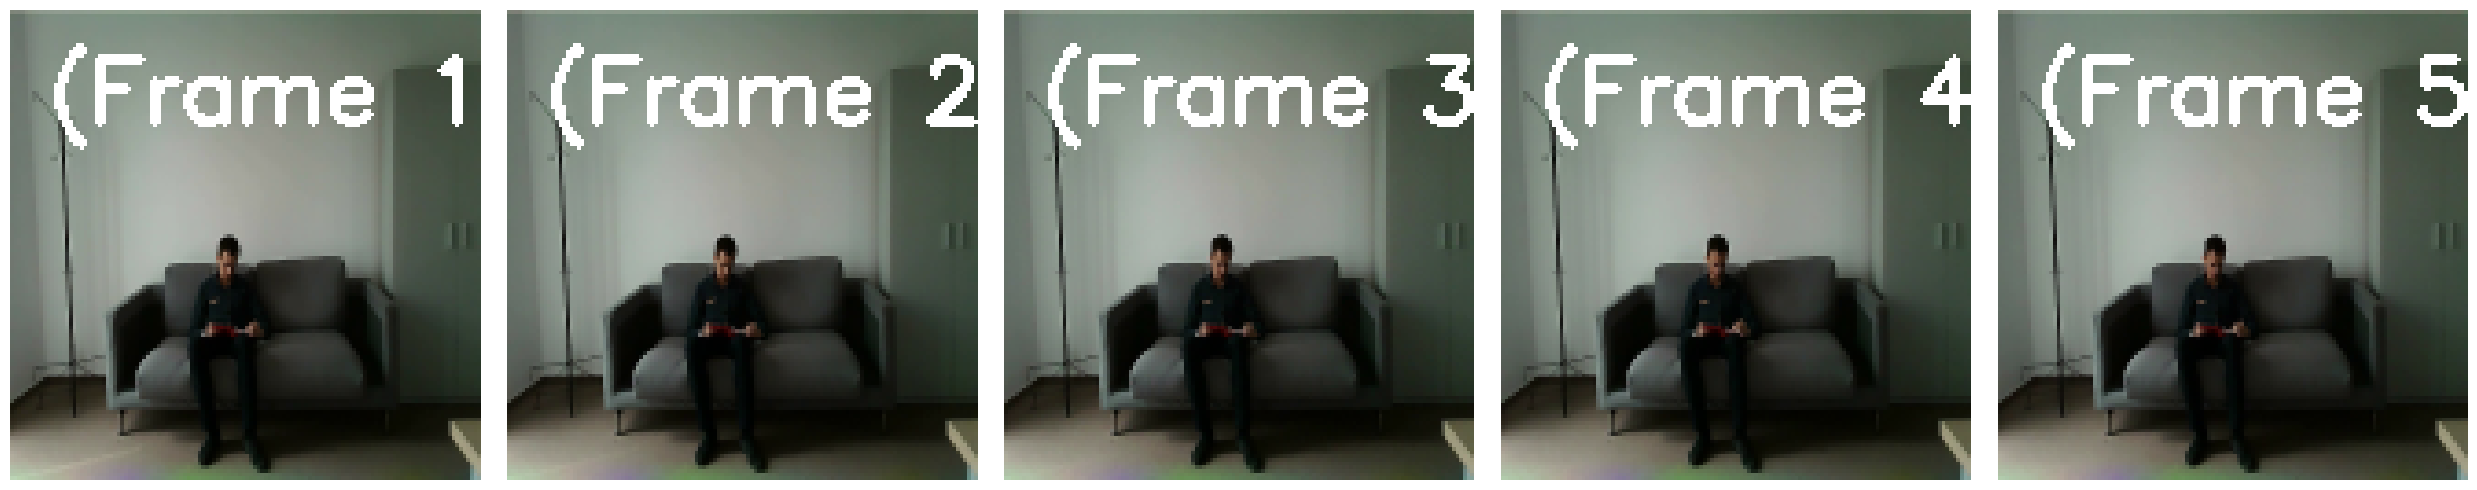

In [23]:
# check summarization
show_sequence(videos[0], [1,2,3,4,5])

In [24]:
video_generator = VideoDataGenerator(
    videos=videos,
    labels=labels,
    batch_size=BATCH_SIZE
)

Total 320 videos and 320 classes


In [25]:
videos, labels = video_generator[0]

videos.shape, labels.shape

((16, 5, 128, 128, 3), (16,))

In [26]:
len(video_generator.videos) 

320

In [27]:
len(video_generator)

20

In [28]:
apply_augmentation(segmentation_frames, video_generator)

Total 320 augmented videos generated
Ready to be merged with original videos...


In [29]:
len(video_generator.temp_videos), len(video_generator.videos)

(320, 320)

In [30]:
video_generator.replace_original()

Successfully replaced, total original videos - 320 and augmented videos 0


In [31]:
len(video_generator.temp_videos), len(video_generator.videos)

(0, 320)

In [32]:
test = np.array(video_generator.videos)

test.shape

(320, 5, 128, 128, 3)

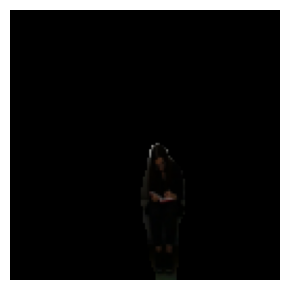

In [33]:
show_frame(test[1,0])

## Apply ***horizontal flip*** (Augmentation)

In [34]:
apply_augmentation(horizontal_flip, video_generator)

Total 320 augmented videos generated
Ready to be merged with original videos...


In [35]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 320, 320
PENDING Total Videos and Class Count: 320, 320


## Apply ***Noise*** (Augmentation)

In [36]:
apply_augmentation(noise_video, video_generator)

Total 640 augmented videos generated
Ready to be merged with original videos...


In [37]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 320, 320
PENDING Total Videos and Class Count: 640, 640


## Apply ***Random Shear x2*** (Augmentation)

In [38]:
apply_augmentation(apply_shear_frames, video_generator, shear_right=0)
apply_augmentation(apply_shear_frames, video_generator, shear_right=1)

Total 960 augmented videos generated
Ready to be merged with original videos...
Total 1280 augmented videos generated
Ready to be merged with original videos...


In [39]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 320, 320
PENDING Total Videos and Class Count: 1280, 1280


In [40]:
# confirm changes to generator
video_generator.confirm()

Successfully added - 1280 videos and 1280 classes.
Now Total - 1600 videos and 1600 classes.
PENDING for Augmentations - 0 videos and 0 classes.


In [41]:
print(f"Checking Video Generator Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")

Checking Video Generator Total Videos and Class Count: 1600, 1600


## Cheking (Output)

(16, 5, 128, 128, 3) (16,)


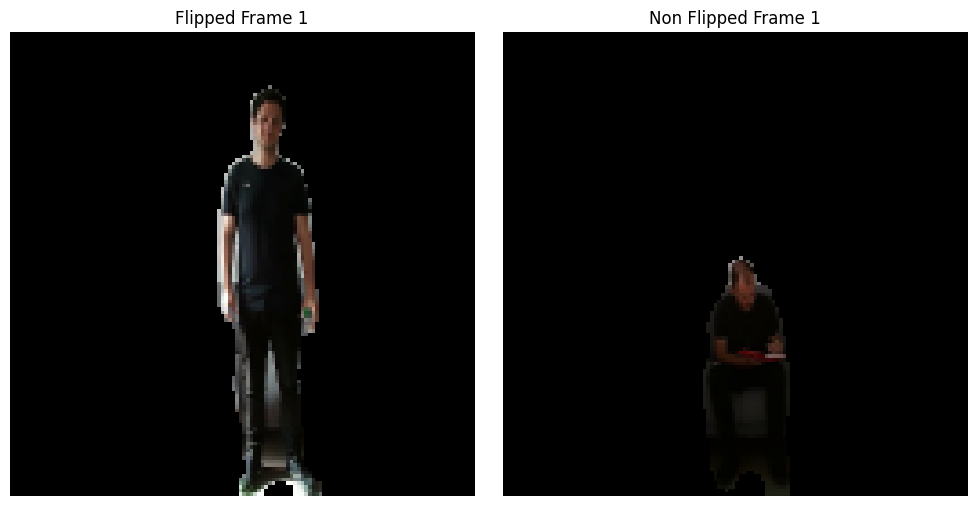

Might be two different action, but to check the flipping focus on the door behind.


In [42]:
# check horizontal flips
videos, labels = video_generator[7]
videos1, labels1 = video_generator[1]

print(videos.shape, labels.shape)

show_frame_vs(videos[0,0],videos1[1,0], title1="Flipped Frame 1", title2="Non Flipped Frame 1")
print("Might be two different action, but to check the flipping focus on the door behind.")

# 🧪 Test Augmentation (Output)
## 🖼️ Horizontal Flip Output

In [43]:
# flipped_video_1 = horizontal_flip(features[0])

# flipped_video_1=np.asarray(flipped_video_1)

# show_frame(flipped_video_1[0])
# flipped_video_1.shape

## 🖼️ Salt and Pepper Noise Output

In [44]:
# noised_video = noise_video(features[0])

# print(noised_video.shape)
# show_frame(noised_video[0])

## 🖼️ Random Shear Output

In [45]:
# print(features.shape)

# sheared_1 = apply_shear_frames(features[0], shear_right=0)
# sheared_2 = apply_shear_frames(features[0], shear_right=1)

# sheared_1 = np.asarray(sheared_1)
# sheared_2 = np.asarray(sheared_2)

# print(sheared_1.shape)
# show_frame(sheared_1[0])
# show_frame(sheared_2[0])

# 📌 Preparing Data for Training

In [46]:
# Clear previous session to free memory
import gc

gc.collect()
tf.keras.backend.clear_session()

## Splitting data for ***Trainig*** and ***Testing***

In [47]:
videos = video_generator.videos
labels = video_generator.labels

videos = np.array(videos, dtype='float32')
labels = np.array(labels)

videos.shape, labels.shape

((1600, 5, 128, 128, 3), (1600,))

In [48]:
from tensorflow.keras.utils import to_categorical

one_hot_encoded_labels = to_categorical(labels)

one_hot_encoded_labels.shape

(1600, 16)

In [49]:
gc.collect()

0

In [50]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(videos,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((1280, 5, 128, 128, 3), (1280, 16), (320, 5, 128, 128, 3), (320, 16))

## Splitting data for ***Training Set*** and ***Validation Set***

In [51]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, train_labels.shape, val_video_frames.shape, val_labels.shape

((1024, 5, 128, 128, 3), (1024, 16), (256, 5, 128, 128, 3), (256, 16))

## Use Generator `Video Data Generator`

In [52]:
# Create the training and validation generators
train_gen = VideoDataGenerator(
    videos=train_video_frames, 
    labels=train_labels, 
    batch_size=BATCH_SIZE,
)

val_gen = VideoDataGenerator(
    videos=val_video_frames, 
    labels=val_labels, 
    batch_size=BATCH_SIZE,
)

len(train_gen), len(val_gen)

Total 1024 videos and 1024 classes
Total 256 videos and 256 classes


(64, 16)

## Inspect ***Generator*** Data on Epochs

In [53]:
features, labels = train_gen[1]

print(train_gen.indices)

train_gen.on_epoch_end()

print(train_gen.indices)

BATCH_SIZE, features.shape, labels.shape

[   0    1    2 ... 1021 1022 1023]
[368 470 236 ... 433 468  99]


(16, (16, 5, 128, 128, 3), (16, 16))

## Compute Class Weight

In [54]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_int are integer labels (not one-hot)
y_int = np.argmax(one_hot_encoded_labels, axis=1)  # or just integer labels if you have them

classes = np.arange(NO_OF_CLASSES)  # e.g. np.arange(16)
class_weights_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_int)

class_weights = dict(zip(classes, class_weights_values))

print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0}


In [55]:
gc.collect()
del videos, one_hot_encoded_labels, labels_train
del features_train, val_labels, train_labels
del val_video_frames, train_video_frames

# ✨ Model Execution
## Creating Model

In [56]:
# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

Loading Xception base model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 5, 4, 4, 2048)       │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       5,244,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_lstm (Dropout)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense (Dropout)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           8,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,379,320 (100.63 MB)

 Trainable params: 26,323,768 (100.42 MB)

 Non-trainable params: 55,552 (217.00 KB)

Model Created Successfully!


## Plot Model Structure

In [57]:
# Plot the structure of the contructed model.
from tensorflow.keras.utils import plot_model

plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

Xception Model Plot saved successfully...


## Model Compile

In [58]:
# Create an Instance of Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ["accuracy"])


## 💪 Model Fit

In [59]:
labels = np.argmax(train_gen.labels, axis=1)  # assuming one-hot encoded
print("Unique labels:", np.unique(labels))
print("NO_OF_CLASSES:", NO_OF_CLASSES)


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
NO_OF_CLASSES: 16


In [60]:
print("Train label shape:", np.shape(train_gen.labels))
print("Val label shape:", np.shape(val_gen.labels))


Train label shape: (1024, 16)
Val label shape: (256, 16)


In [61]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)



print(f"Dataset - {DATASET_NAME}")
print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS} videos/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

print("\n")

print(f"Training started for {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")

model_history = xlstm_model.fit(
    train_gen.as_dataset(),
    validation_data=val_gen.as_dataset(),
    epochs=EPOCHS,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping_callback, lr_scheduler]
)

Dataset - Precis Har Rgb
There are total 16 classes, selected 16 classes
Setting 20 videos/class to train the model.
Image size 128x128 with 5 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


Training started for 1024 videos of 16 classes with 256 videos for validation...
Epoch 1/30


I0000 00:00:1751780870.055960      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


     64/Unknown 104s 665ms/step - accuracy: 0.0978 - loss: 28.6713

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 788ms/step - accuracy: 0.0980 - loss: 28.6578 - val_accuracy: 0.1719 - val_loss: 26.0581 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 686ms/step - accuracy: 0.1908 - loss: 25.1102 - val_accuracy: 0.3281 - val_loss: 23.2274 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - accuracy: 0.3496 - loss: 21.9400 - val_accuracy: 0.5234 - val_loss: 20.3921 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 688ms/step - accuracy: 0.5401 - loss: 18.8105 - val_accuracy: 0.5469 - val_loss: 17.8200 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - accuracy: 0.6511 - loss: 16.1943 - val_accuracy: 0.6055 - val_loss: 15.5975 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - accuracy: 0.7891 - loss: 14.1072 - val_accuracy: 0.6680 - val_loss: 13.5838 - learning_rate: 1.0000e-04
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - a

# Evaluation

## ⚡ Model Evaluate

In [62]:
# previous code
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.8020 - loss: 3.6407


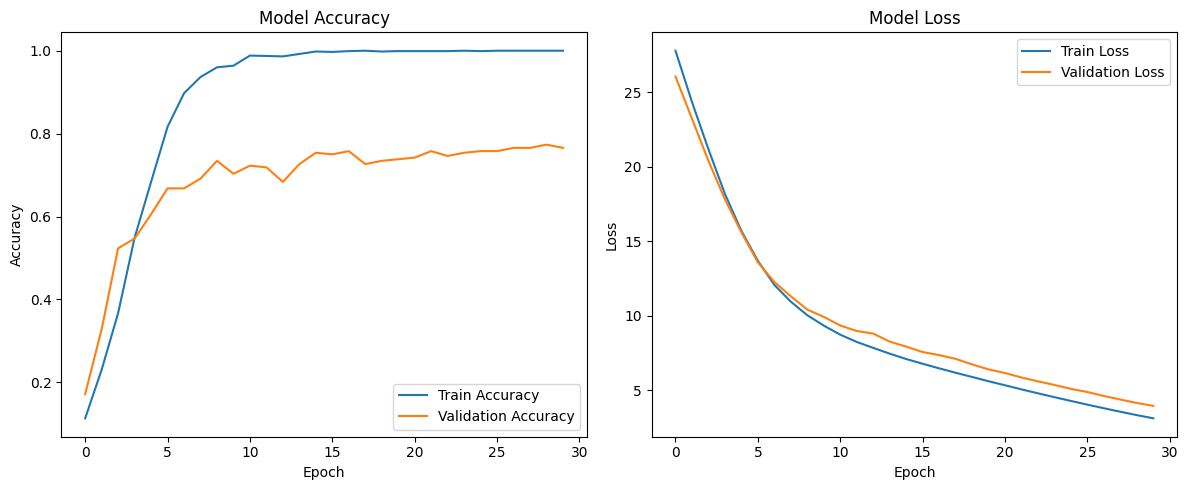

In [63]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 📈 Confusion Matrix

Total 320 videos and 320 classes
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step
True classes shape: (320,)
Predicted classes shape: (320,)
Classification Report:
                                 precision    recall  f1-score   support

                          write       0.89      0.68      0.77        25
                      sit still       0.41      0.53      0.46        17
                       sit down       0.95      1.00      0.97        19
move hands in front of the body       0.95      1.00      0.97        19
               raise one leg up       0.82      0.88      0.85        16
            drink from a bottle       0.68      0.63      0.65        27
                       stand up       0.68      0.76      0.72        17
                           read       0.71      0.77      0.74        22
                    throw paper       0.81      0.63      0.71        27
                           walk       0.83      1.00      0.90        19
               drink from a mug       0.7

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


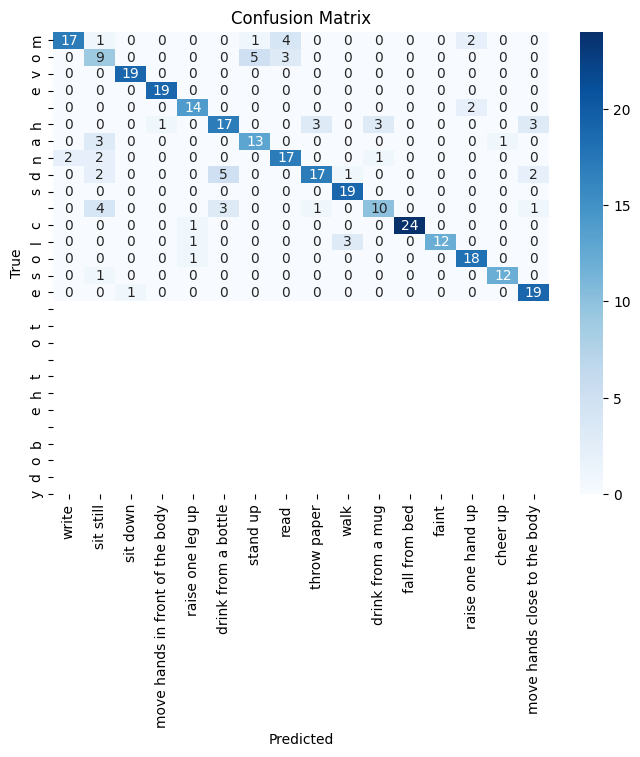

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create test generator with batch_size matching test set size
test_gen = VideoDataGenerator(
    videos=features_test,
    labels=labels_test,
    batch_size=4,  # Process all test samples at once
)

# Get predictions
predictions = xlstm_model.predict(test_gen.as_dataset())
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

# Verify shapes
print(f"True classes shape: {true_classes.shape}")
print(f"Predicted classes shape: {predicted_classes.shape}")
assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST[-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()